--------------------------------------------------------------------------------

<div style="text-align: center;">
    <h1 style="font-weight: bold;">Data anonymization </h1>
</div>

-------------------------------------------------------------------

# **Introduction**

Following our first project, `project01-pseudonymization`, which demonstrated the limitations of pseudonymization, this second project focuses on other techniques in data anonymization, with a more robust approach to protecting sensitive information. While pseudonymization can reduce the risk of direct identification, it remains vulnerable to re-identification attacks, especially when combined with external datasets. Differential privacy, on the other hand, aims to ensure that individuals cannot be re-identified under any reasonable assumptions.

Key concepts :
- **Anonymization** - A definition of the concept
- **k-Anonymity** – A traditional approach to anonymization and its weaknesses  
- **Differential Privacy** – Theoretical foundation, sensitivity, the Laplace mechanism and the Gaussian mechanism
- **PATE Framework** – A privacy-preserving approach using teacher-student models  

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.metrics import classification_report
from sklearn import metrics

# I. Anonymization

`Data anonymization` is the process of transforming, encrypting, or removing personally identifiable information (PII) from datasets to protect individuals’ privacy while still allowing the data to be used for analysis, research, and other legitimate purposes. This process ensures that the data cannot be traced back to a specific person, even when combined with other sources of information.

Anonymization techniques include **data masking**, where sensitive data is replaced or obscured; **pseudonymization**, which replaces identifying details with artificial identifiers; **generalization**, where data is grouped into broad categories to reduce specificity; and **differential privacy**, which introduces noise into datasets to prevent identification of individuals.

Data anonymization is widely used in industries such as healthcare, finance, and social sciences to comply with privacy regulations like **GDPR (General Data Protection Regulation) and HIPAA (Health Insurance Portability and Accountability Act)** while maintaining the value of data for analytics and decision-making. Proper anonymization techniques help organizations balance privacy protection with the need for data-driven insights, reducing the risk of data breaches and unauthorized access.

As data anonymization techniques have evolved, various methods have been developed to protect sensitive information while preserving data utility. Among the earliest and most influential approaches was k-anonymity, which played a crucial role in shaping modern privacy-preserving techniques. While newer models have emerged to address its limitations, k-anonymity remains a foundational concept in the field of data privacy. The next section explores its principles, impact, and the challenges that led to the development of more advanced methods.

# II. K-anonymity

`K-anonymity` is a privacy technique that ensures each individual in a dataset is indistinguishable from at least k-1 others. To achieve this, each grouping of quasi-identifiers must contain at least k individuals. If any grouping has fewer than k, the dataset does not satisfy k-anonymity. 

Let's have a look at an example :

In [2]:
# Specify the path to your CSV file
file_path = "D:/PORTFOLIO/project02-data-anonymization/data_resources/dataset_small.csv"

# Read the CSV file into a Pandas DataFrame
small_df = pd.read_csv(file_path)

In [3]:
small_df.head(3)

,Zip,Age,Workclass,Education,Marital Status,Occupation,Relationship,Race,Sex,Hours per week,Country
0,27241,50,Private,Some-college,Divorced,Craft-repair,Not-in-family,White,Male,40,United-States
1,77306,28,Private,HS-grad,Married-civ-spouse,Craft-repair,Husband,White,Male,40,United-States
2,99721,36,Self-emp-not-inc,Prof-school,Married-civ-spouse,Prof-specialty,Husband,White,Male,60,United-States


We implement a function to test whether k-anonymity is satisfied :

In [4]:
def analyse_k_anon(df, k, qids):
    # group all categories according to the qids and count them
    grouped_df = df.groupby(qids).size()
    #selects rows that do not conform to k-anonymity, if len = 0 then k-anonymity is satisfied
    return len(grouped_df[grouped_df<k])==0

Does`small_df` satisfy the 2-anonymity with the QIDs = ['Sex', 'Race']?

In [5]:
print(analyse_k_anon(small_df, 2, ['Sex','Race']))

True


There is no group of individuals with less than 2 people according to attributes (gender, race), so 2-anonymity is satisfied for these QIDs.

What is the list of quasi-identifier pairs for which `small_df` satisfies 2-anonymity?

In [6]:
def check_pair(df, k):
    cols_df = df.columns
    for i in range(0,len(cols_df)):
        for j in range(i+1,len(cols_df)):
            if analyse_k_anon(df, k, [cols_df[i],cols_df[j]]):
                print("Valid pairs: " + cols_df[i] + "   " +cols_df[j])

In [7]:
check_pair(small_df, 2)

Valid pairs: Education   Sex
Valid pairs: Marital Status   Sex
Valid pairs: Relationship   Sex
Valid pairs: Race   Sex


**Limitations of k-anonymity**

While k-anonymity provides some level of privacy, it has significant weaknesses. One of the main limitations is that it relies on the assumption that adversaries do not have access to additional external information. If an adversary does possess such knowledge (e.g., public records or social media profiles), they can cross-reference the anonymized data and potentially re-identify individuals. This was famously demonstrated with the [Netflix Prize dataset](https://medium.com/%40EmiLabsTech/data-privacy-the-netflix-prize-competition-84330d01cc34), where researchers were able to de-anonymize users by combining the Netflix ratings with publicly available IMDb ratings. This vulnerability showed that k-anonymity alone cannot guarantee privacy in real-world scenarios.

&nbsp;

# **III - Differential privacy**

The vulnerabilities of k-anonymity, highlighted by the Netflix Prize example, led to the development of [`differential privacy by Cynthia Dwork`](https://www.cis.upenn.edu/%7Eaaroth/Papers/privacybook.pdf) and her colleagues in 2006. Dwork, a leading computer scientist, introduced this framework to address the vulnerabilities of earlier methods. Unlike k-anonymity, differential privacy **adds controlled noise to data**, ensuring that the inclusion or exclusion of any individual’s data has minimal impact on the outcome. This approach provides strong mathematical guarantees, making it much harder for adversaries to identify individuals, even with external data. It has become the gold standard in privacy protection for data analysis.

**1) Sensitivity**

One of the core concepts behind differential privacy is **sensitivity**, which determines how much a query result can be influenced by a single individual's data. There are two main types:

* **Global L1 sensitivity** of a function is a measure of how much the result of that function can change when a single individual is added or removed from a database

$$
\Delta_1 f = \max_{D, D'} \| f(D) - f(D') \|_1
$$
Where:
- D and D' are datasets differing by one record
- 𝑓 is a function applied to the dataset
- || ||1 represents the L1 norm


Usage:
L1 sensitivity is used when applying **Laplace noise**, since the Laplace mechanism preserves ε-differential privacy with noise proportional to Δ1f
  
* **Global L2 Sensitivity** measures the maximum change using the Euclidean distance (square root of squared differences), typically used for more complex queries

$$
\Delta_2 f = \max_{D, D'} \| f(D) - f(D') \|_2
$$
Where:
- || ||2 represents the L2 norm (Euclidean distance)


Usage: L2 sensitivity is used when applying **Gaussian noise**, since the Gaussian mechanism preserves 
((ε,δ))-differential privacy with noise proportional to Δ2f

---------------------------------------------------------------------------------

**L1 global sensitivity example:**

| Employee | Salary |
|----------|--------|
| 1        | 50     |
| 2        | 60     |
| 3        | 70     |

Original sum: S(D) = 50 + 60 + 70 = 180
  
**Case 1: Remove Employee 1**

| Employee | Salary |
|----------|--------|
| 2        | 60     |
| 3        | 70     |

- New sum:  S(D') = 60 + 70 = 130
- Change: ΔS = |180 - 130| = 50

**Case 2: Add Employee 4 with Salary 100**

| Employee | Salary |
|----------|--------|
| 1        | 50     |
| 2        | 60     |
| 3        | 70     |
| 4        | 100    |

- New sum: S(D'') = 50 + 60 + 70 + 100 = 280
- Change: ΔS = |180 - 280| = 100

The L1 sensitivity is the maximum change in the sum, which is: **L1 Sensitivity = max(50, 100) = 100**

&nbsp;

**2) Laplace mechanism**

The `Laplace Mechanism` is a method in differential privacy that adds noise drawn from the Laplace distribution to a query result. The noise scale is determined by the L1 sensitivity of the function and the privacy parameter epsilon

Epsilon (ε) controls the privacy-accuracy tradeoff:

* **Smaller ε** (ex : 0.1) → More noise → Stronger privacy 
* **Larger ε** (ex : 1.0) → Less noise → Higher accuracy 

The Laplace noise is sampled from Lap(0,Δ𝑓/𝜖), where Δ𝑓 is the L1 sensitivity of the function

In [8]:
#implementation of the Laplace mechanism
def laplace_mech(v, sensitivity, epsilon):
    return v + np.random.laplace(loc=0, scale=sensitivity / epsilon)

In [9]:
data_WDI = pd.read_csv("D:/PORTFOLIO/project02-data-anonymization/data_resources/pseudonymized_data.csv")
data_WDI = data_WDI.dropna()
data_WDI.head(3)

,ID,Age,Workclass,fnlwgt,Education,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country,Target
0,d8373cad,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,facff35e,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,6a22cf1e,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K


We implement a function `query_1`to answer the question: 'How many people have never been married?'

In [10]:
def query_1():
    return len(data_WDI[data_WDI["Marital Status"]=="Never-married"])
    
query_1()

9726

In [11]:
# unit test
assert query_1() == 9726

&nbsp;

We want to implement a differentially confidential query and graphically compare our results when we change the value of epsilon. We will study the accuracy of our differential query over 1000 calls.

&nbsp;
Here our global sensitivity L1 is 1, because with the change of a single person we can switch to a count of + or - 1 person who has never been married in the dataset. 

In [12]:
# Our differentially confidential query
def query_1_dp(epsilon):
    return laplace_mech(query_1(),1,epsilon)
    
# returns the relative error percentage between an original request and its private version
def pct_error(orig, priv):
    return 100.0*np.abs(orig - priv)/orig
    
def graph_error_1(epsilon):
    list_errors = []
    
    for _ in range(1000):  
        orig = query_1()  
        priv = query_1_dp(epsilon)  
        list_errors.append(pct_error(orig, priv))  

    plt.xlabel('Relative percentage error (%)')
    plt.ylabel('Frequency')
    
    # Create histogram
    counts, bin_edges, patches = plt.hist(list_errors, bins=20, alpha=0.5, edgecolor="black")

    # Add labels on top of bars
    for i in range(len(counts)):  
        plt.text(bin_edges[i] + (bin_edges[1] - bin_edges[0]) / 2, counts[i], 
                 f'{int(counts[i])}', ha='center', va='bottom', fontsize=10)

    plt.show()

How accurate are the results of our 1000 queries with epsilon = 0.1 and epsilon = 1.0?

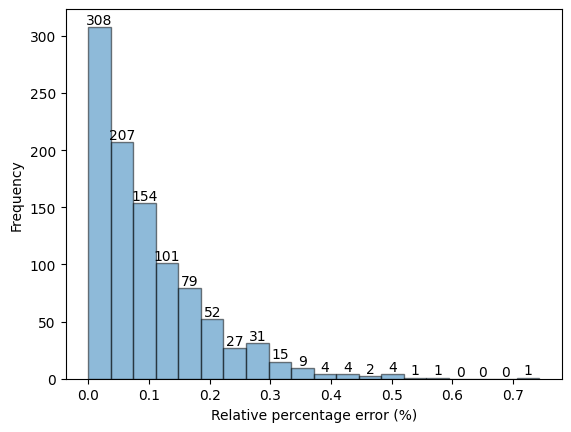

In [13]:
graph_error_1(0.1)

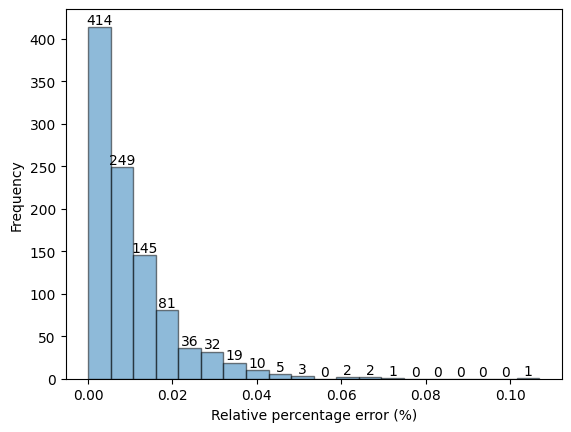

In [14]:
graph_error_1(1.0)

For ε = 1.0, most relative error percentages fall between 0% and 0.05%, whereas for ε = 0.1, they are mostly between 0% and 0.5%. A smaller ε value results in a higher relative error. This suggests that ε = 1.0 provides more accurate results but reduces data confidentiality. 

In conclusion, as ε approaches 0, the generated data becomes less accurate, ensuring greater confidentiality

Having established the fundamentals of differential privacy and the Laplace mechanism, we now will be exploring how these principles can be applied in practical machine learning settings. One notable framework that leverages differential privacy is Private Aggregation of Teacher Ensembles (PATE).

&nbsp;

**3) PATE framework** 

The **[`PATE framework`](https://www.cleverhans.io/privacy/2018/04/29/privacy-and-machine-learning.html)(Private Aggregation of Teacher Ensembles)** is designed for **training machine learning models**. It uses a collection of teacher models, each trained on disjoint subsets of the data. During the inference phase, these teacher models collaboratively vote on the output, and **differential privacy** is applied to the aggregation of their predictions. The result is a mechanism that can be used to train a student model in a privacy-preserving manner, offering privacy guarantees for the original data while maintaining the predictive power of the model. By carefully **controlling the amount of noise added** to the aggregation process, PATE ensures that individual data points remain protected, even as the model learns from the ensemble.

In the following sections, we will explore the fundamental aspects of PATE, its privacy-preserving mechanisms, and its practical application using a RandomForestClassifier on the Bike Sharing dataset. Through this example, we will demonstrate how PATE can be effectively utilized in real-world scenarios while balancing privacy and model performance.


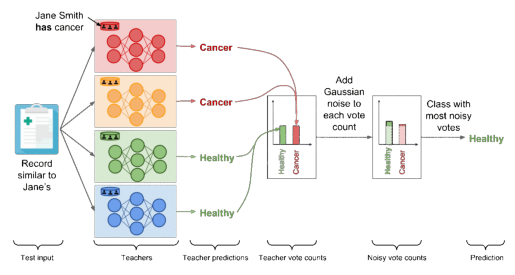

In [15]:
# Specify the path to the image
image_path = "D:/PORTFOLIO/project02-data-anonymization/data_resources/pate-aggregation.gif"

# Read the image
img = mpimg.imread(image_path)

# Display the image
plt.imshow(img)
plt.axis('off')  # Hide axes
plt.show()

**a) Preprocessing**

For this last part, we will use the  dataset [`UCI Bike sharing`](https://archive.ics.uci.edu/ml/datasets/bike+sharing+dataset). We will use this dataset to predict whether the number of bixi users per hour is greater than a certain number (in this case the median).

In [16]:
# Specify the path to your CSV file
file_path = "D:/PORTFOLIO/project02-data-anonymization/data_resources/bikesharing.csv"

# Read the CSV file into a Pandas DataFrame
df = pd.read_csv(file_path)

df.head(3)

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32


We load the dataset and convert it into a binary classification problem, where we predict if the number of bike-sharing users per hour is greater than the median.

In [17]:
# change into a classification problemCliquez pour utiliser cette solution
df["cnt"] = df["cnt"].apply(lambda x: 0 if x < df.cnt.median() else 1 )

In [18]:
df.drop(['instant', 'dteday'], axis=1, inplace=True)
df = df.dropna()
df = shuffle(df)
df.head(3)

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
10151,1,1,3,1,0,0,0,2,0.38,0.3939,0.34,0.1940,16,60,0
14247,3,1,8,20,0,2,1,1,0.64,0.6061,0.73,0.0000,62,296,1
5396,3,0,8,18,0,3,1,1,0.76,0.6970,0.55,0.2537,86,470,1


**b)Defining the Laplace Mechanism for Differential Privacy**

In [19]:
y = df["cnt"]
X = df.drop(["cnt",], axis=1)

In [20]:
def laplace_mech_vec(vec, sensitivity, epsilon):
    v = []
    for x in vec:
        v.append(laplace_mech(x, sensitivity, epsilon))
    return v

We divide our sensitive dataset into multiple disjoint subsets, ensuring that each subset contains unique data points with no overlap between them

In [21]:
#Partition the dataset for each teacher
def partition_dataset(data, labels, nb_teachers, teacher_id):

    # Sanity check
    assert len(data) == len(labels)
    assert int(teacher_id) < int(nb_teachers)

    # This will floor the possible number of batches
    batch_len = int(len(data) / nb_teachers)

    # Compute start, end indices of partition
    start = teacher_id * batch_len
    end = (teacher_id+1) * batch_len

    # Slice partition off
    partition_data = data[start:end]
    partition_labels = labels[start:end]

    return partition_data, partition_labels

**c) Train Teacher Models**

In [22]:
#Return the list of teachers' models
def getListTeachers(X, y, nb_teachers):
    
    list_Teachers = []
    
    for i in range(0,nb_teachers):
        data, labels = partition_dataset(X, y, nb_teachers, i)
        X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2,shuffle=False)
        
        #Training the model 
        clf = RFC(n_estimators=100)
        model = clf.fit(X_train,y_train)
        
        list_Teachers.append(model)
    
    return list_Teachers  

In [23]:
# Returns the score counter assigned by the teachers
def score(elem, teachers) : 
    score=[0,0]
    # score[0] : counter 0
    # score[1] : counter 1
    
    for t in teachers:
        pred_elem = t.predict(elem) #predict 0 or 1

        if (pred_elem==0):
            score[0] = score[0]+1
        if (pred_elem==1):
            score[1] = score[1]+1

    return score 

In [24]:
# Returns the noisy item with the highest score 
def report_noisy_max(res, sensitivity, epsilon):
    noisy_res=[]
    
    for i in range(0,len(res)):
        new_score = res[i] + laplace_mech(len(res), sensitivity, 1/epsilon)
        noisy_res.append(new_score)
    
    if(noisy_res[0]>noisy_res[1]):
        return 0
    else :
        return 1

In [25]:
# Returns the item with the highest score 
def report_max(res):
    if(res[0]>res[1]):
        return 0
    else :
        return 1

In [26]:
#We split our data
teachers_ratio = 0.50 #50% for the teachers
student_ratio = 0.25 #25% for the student
test_ratio = 0.25 #25% for the test

X_teachers, X_test, y_teachers, y_test = train_test_split(X, y, test_size=1 - teachers_ratio,shuffle=False)

X_student, X_test, y_student, y_test = train_test_split(X_test, y_test, test_size=test_ratio/(test_ratio + student_ratio),shuffle=False) 

In [27]:
#We train a ML model (random forest), called a teacher, on each of these partitions

# If we partition our dataset into 3 teachers
nb_teachers = 3

# We train our teachers
list_teachers = getListTeachers(X_teachers, y_teachers, nb_teachers)

**d) Aggregate Teacher Outputs**

In [28]:
#Counting + noise

y_student = [] #our final teachers prediction with noise

y_true_prediction = []

for i in range(0,len(X_student)):
    elem = X_student.iloc[i:i+1,:]

    #We aggregate the predictions made invidually by each teacher to form a single common prediction
    vote_counts = score(elem, list_teachers)
    
    #True prediction
    result = report_max(vote_counts)
    y_true_prediction.append(result)

    # We add random noise sampled from the Laplace distribution
    # epsilon = 1.0
    noisy_vote_counts = report_noisy_max(vote_counts,1,1)
    y_student.append(noisy_vote_counts)

print("NOISY : ")
print(y_student)
print(len(y_student))

NOISY : 
[1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 

**e) Train the student model**

In [29]:
#Check similarities
common_pred = 0
for i in range(0,len(y_student)):
    if(y_student[i]==y_true_prediction[i]):
        common_pred= common_pred+1

print(common_pred)

4042


In [30]:
#The student is trained by transfering knowledge acquired by the teacher ensemble in a privacy-preserving way

clf_student = RFC(n_estimators=100)
    
#Training the model 
clf_student.fit(X_student,y_student)

RandomForestClassifier()

In [31]:
#Finally, we get a prediction from the test set
y_pred_student=clf_student.predict(X_test)

print(classification_report(y_test, y_pred_student))
print("Accuracy:",metrics.accuracy_score(y_test, y_pred_student))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2185
           1       0.99      0.99      0.99      2160

    accuracy                           0.99      4345
   macro avg       0.99      0.99      0.99      4345
weighted avg       0.99      0.99      0.99      4345

Accuracy: 0.9868814729574223


Compared with a non-confidential model, we notice that it has very few accuracy losses during classification.

# **Conclusion**

In an era where data-driven decision-making is ubiquitous, ensuring privacy while maintaining data utility is a crucial challenge. Throughout this essay, we explored key concepts in privacy-preserving techniques, starting with pseudonymization and its limitations against membership inference attacks. We then examined k-anonymity as a foundational approach, though one that remains vulnerable to sophisticated adversaries. Differential privacy emerged as a more robust solution, offering mathematical guarantees of privacy by introducing controlled noise, as seen in the Laplace mechanism. Finally, the PATE framework demonstrated how ensemble learning can enhance privacy through knowledge distillation while leveraging the strengths of differential privacy.

Ultimately, while no single method offers absolute security, differential privacy provides a strong foundation for mitigating risks in data sharing and machine learning. As research advances, refining these techniques will be essential to balancing privacy, accuracy, and usability in an increasingly data-driven world.

Sources :
- https://www.imperva.com/learn/data-security/anonymization/?utm_source=chatgpt.com
- https://www.heavy.ai/technical-glossary/data-anonymization?utm_source=chatgpt.com
- https://www.immuta.com/blog/data-anonymization-techniques/?utm_source=chatgpt.com
- https://www.cis.upenn.edu/%7Eaaroth/Papers/privacybook.pdf
- https://www.microsoft.com/en-us/research/wp-content/uploads/2008/04/dwork_tamc.pdf
- https://cleverhans.io/privacy/2018/04/29/privacy-and-machine-learning.html
- https://www.etsmtl.ca/etudes/cours/gti720

<span style="font-size: 11px;">Copyright © 2024 Laure Bouzerand. All rights reserved.
This notebook and its source code is protected by copyright law. You may not reproduce, distribute, or use this work without the express written permission of the copyright holder.
</span>